In [1]:
from collections import defaultdict

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline
pd.options.display.float_format = "{:.2f}".format

In [2]:
import warnings

warnings.filterwarnings("ignore")

# Уменьшение размерности 

# PCA - Principal Component Analysis (метод главных компонент)

Хорошая [статья](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) с объяснением внутренностей. 

Очень красивая [визуализация](http://setosa.io/ev/principal-component-analysis/).

**Основная цель:** найти подпространства меньшей размерности, в ортогональной проекции на которые разброс данных (a.k.a дисперсия, то есть среднеквадратичное отклонение от среднего значения) максимален

* Позволяет уменьшить число переменных, выбрав самые изменчивые из них
* Новые переменные являются линейной комбинацией старых переменных

![](https://miro.medium.com/max/602/1*H38t3YUv_QktLwalzDYRRg.png)

Будем выбирать такую ось, в которой сохраняется максимальное количество дисперсии. 

Так мы потеряем как можно меньше информации при проецировании.   

Следующая ось ортогональна первой, выбирается из всех других осей как ось с наибольшей оставшейся дисперсией.

Вектор, описывающий такую ось называется главной компонентой (principal component)

**Алгоритм:**

1. **Стандартизируем данные (если не в одном масштабе)**
2. Считаем матрицу корреляций или ковариаций по нашим данным
3. Получаем собственные вектора и собственные значения по матрице корреляций/ковариаций (или используем SVD)
4. Сортируем собственные значения по убыванию (чем выше собственное значение - тем выше дисперсия, которую объясняет соответствующая компонента). 
5. По вкусу - выбираем $k$ собственных значений, где $k < d$ (изначальной размерности данных), чтобы сократить размерность
6. Берем соответствующие собственные вектора (отсортированные в том же порядке, что и собственные числа) и составляем из них матрицу проекции $W$
7. Умножаем исходные данные $X$ на $W$ и получаем матрицу главных компонент.

## Поехали

In [3]:
from sklearn.decomposition import PCA

In [4]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X_iris = iris.data
y_iris = iris.target

scaler = StandardScaler()

X_iris_scaled = scaler.fit_transform(X_iris)

pca = PCA()
pca.fit(X_iris_scaled)

PCA()

### Объяснённая дисперсия

Доля объясненной дисперсии используют для выбора числа компонент. Обычно выбирают такое число компонент, которое объясняет $90\%$ или $95\%$ дисперсии.

In [5]:
pca.explained_variance_ratio_

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

In [6]:
0.72962445 + 0.22850762 + 0.03668922

0.99482129

In [7]:
np.cumsum(pca.explained_variance_ratio_)

array([0.72962445, 0.95813207, 0.99482129, 1.        ])

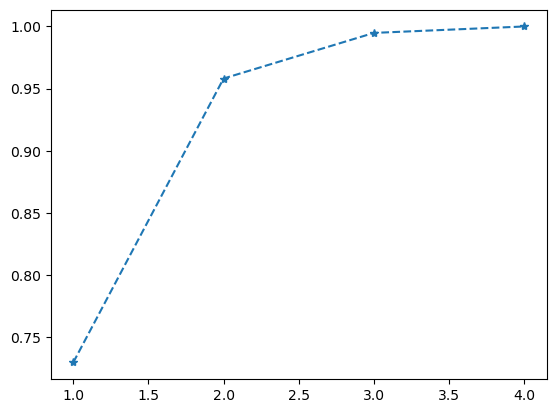

In [8]:
plt.plot(range(1, 5), np.cumsum(pca.explained_variance_ratio_), "*--");

In [9]:
x_new = PCA(n_components=2).fit_transform(X_iris_scaled)
x_new.shape

(150, 2)

In [10]:
x_new[0]

array([-2.26470281,  0.4800266 ])

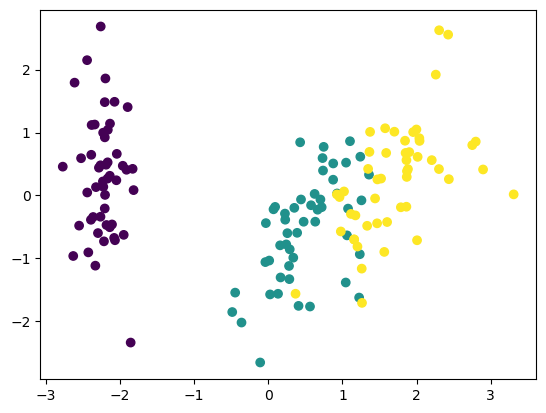

In [11]:
plt.scatter(x_new[:, 0], x_new[:, 1], c=y_iris);

### Данные посложнее - MNIST

Посмотрим, как методы снижения размерности помогут решить задачу [MNIST](http://yann.lecun.com/exdb/mnist/).

MNIST dataset — это база данных, в которой хранятся образцы написания рукописных цифр. Она состоит из 70 тысяч картинок одинакового размера, где изображены написанные от руки цифры. Каждое изображение представляет собой черно-белую картинку 28 на 28 пикселей, для которой необходимо предсказать лейбл от 0 до 9.

**Вопрос:** какой это тип задач?

In [12]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

In [13]:
X.shape, y.shape

((70000, 784), (70000,))

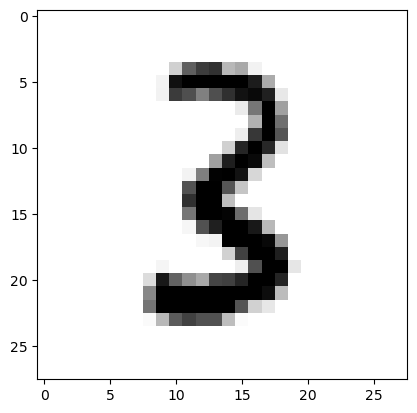

In [14]:
plt.imshow(np.array(X)[50000].reshape(28, 28), cmap=plt.cm.gray_r);

In [15]:
pca = PCA()
pca.fit(scaler.fit_transform(X))
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
d

238

In [16]:
d = np.argmax(cumsum >= 0.95) + 1
d

332

In [17]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

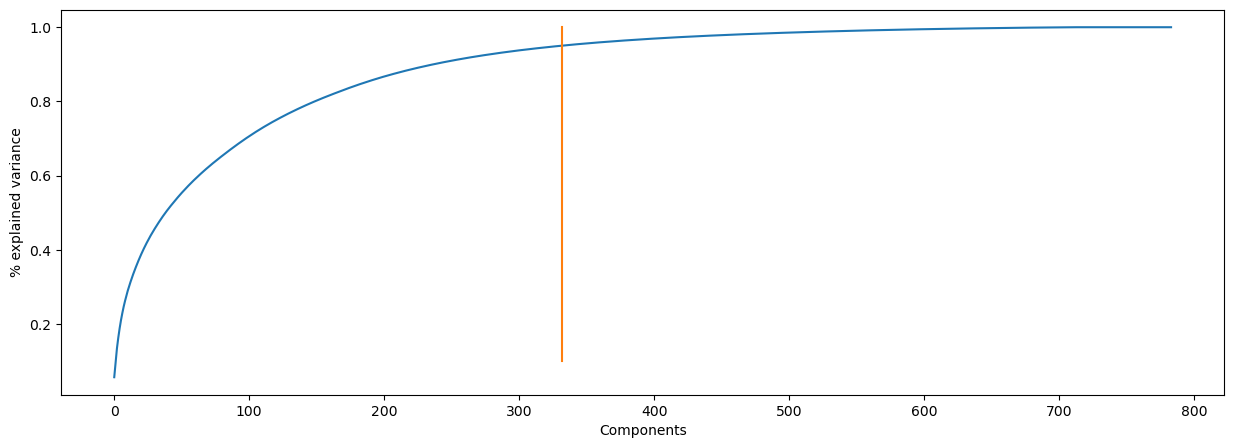

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(cumsum)
plt.plot([d, d], [0.1, 1])
plt.xlabel("Components")
plt.ylabel("% explained variance")
plt.show()

* PCA понижает размерность признакового пространства
* Новые компоненты являются линейной комбинацией исходных признаков
* Новые компоненты - ортогональны
* Можно применять в моделях и для визуализации
* Работает не всегда :(

# Применение для визуализации

In [19]:
idx = np.random.randint(X.shape[0], size=1000)
X_sample = np.array(X)[idx, :]
y_sample = np.array(y)[idx]

X_sample.shape, X.shape, y_sample.shape, y.shape

((1000, 784), (70000, 784), (1000,), (70000,))

In [20]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_sample)

In [21]:
X_reduced.shape

(1000, 2)

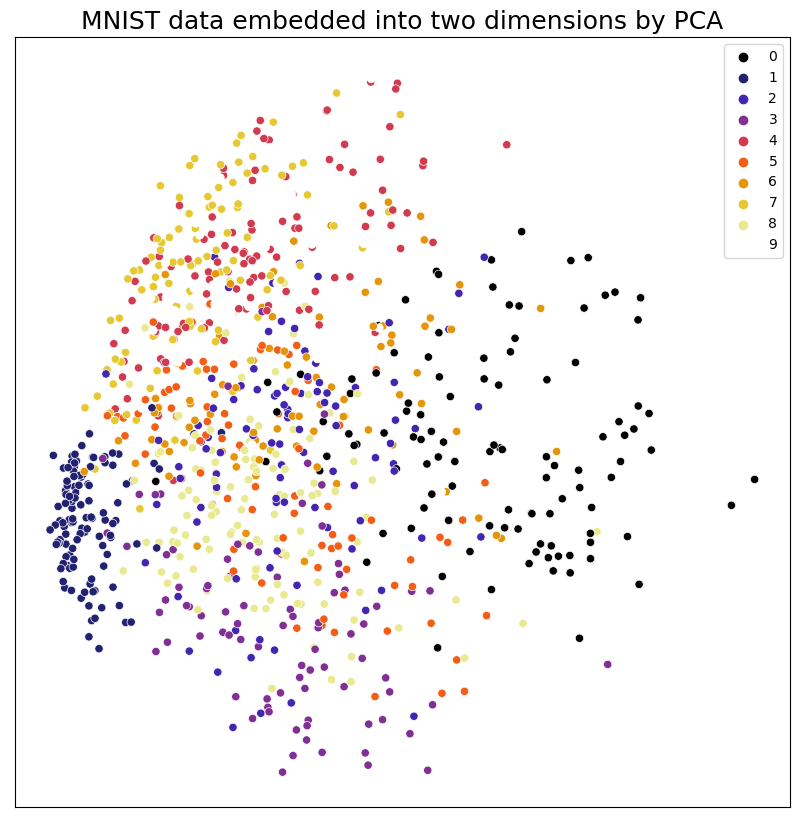

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=y_sample.astype(int),
    palette="CMRmap",
    legend="full",
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by PCA", fontsize=18)
plt.show()

# TSNE

## t-Distributed Stochastic Neighbour Embedding



**Эффективные реализации TSNE:**
- https://github.com/DmitryUlyanov/Multicore-TSNE
- https://github.com/CannyLab/tsne-cuda

[Статья](https://distill.pub/2016/misread-tsne/), как эффективно использовать How to use TSNE.

**[t-SNE Article](http://lvdmaaten.github.io/tsne)**


In [23]:
#!pip install MulticoreTSNE-modified==0.1.post2

In [24]:
from sklearn.manifold import TSNE

# from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(X_sample)

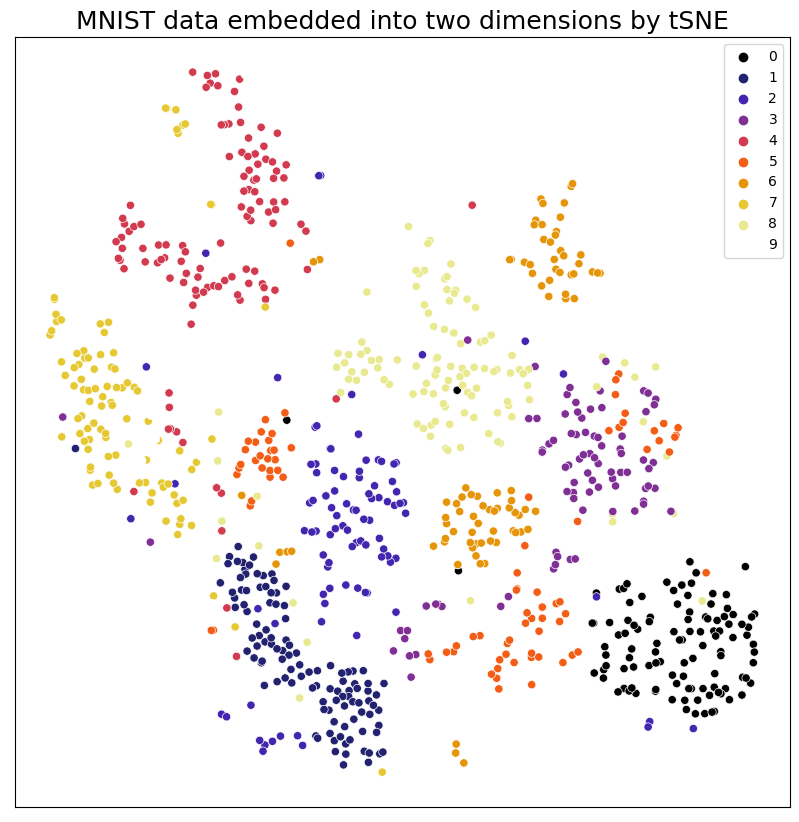

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0],
    y=tsne_transformed[:, 1],
    hue=y_sample.astype(int),
    palette="CMRmap",
    legend="full",
)
plt.title("MNIST data embedded into two dimensions by tSNE", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

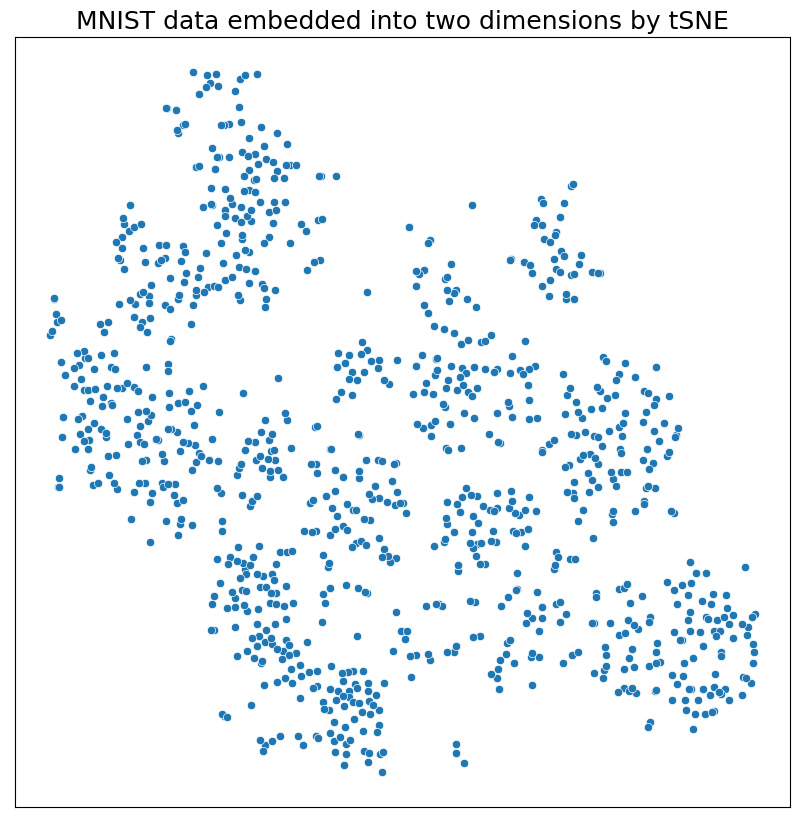

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0],
    y=tsne_transformed[:, 1],
    # hue=y_sample.astype(int),
    # palette="CMRmap",
    # legend='full'
)
plt.title("MNIST data embedded into two dimensions by tSNE", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

# UMAP

Как tSNE, только круче (но не всегда)

[Статья](https://pair-code.github.io/understanding-umap/) про UMAP.

In [27]:
# Google Colab
# !pip install umap-learn

In [28]:
import umap

In [29]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_sample)

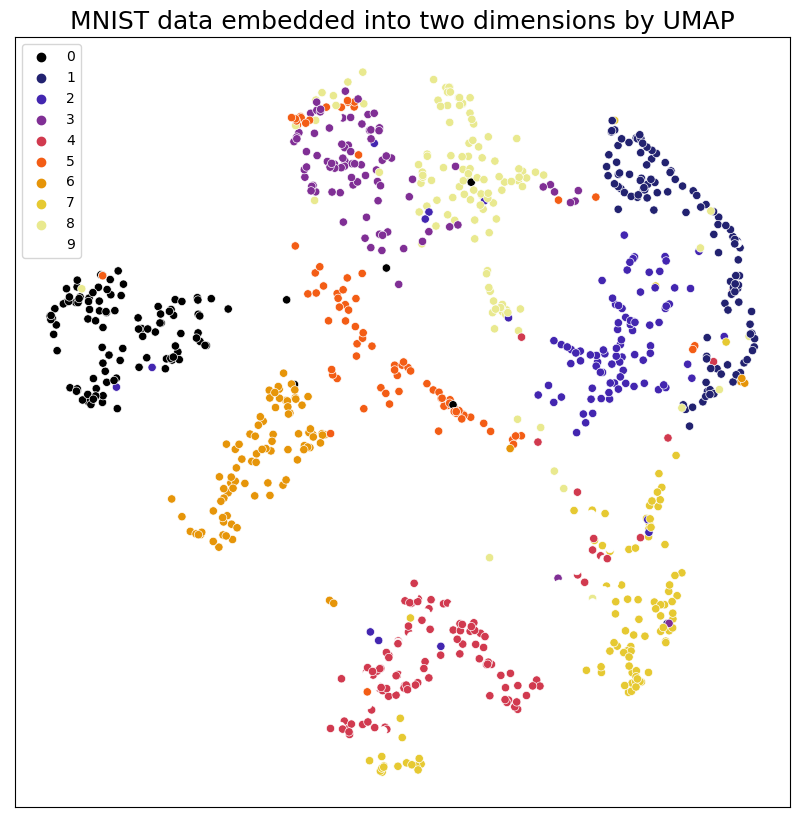

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_sample.astype(int),
    palette="CMRmap",
    legend="full",
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)

plt.show()

# Bonus: для моделей

Задача диагностики поциентов с [Kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/).

Признаки:

1) ID number 

2) Diagnosis (M = malignant, B = benign) 

3-32)



In [31]:
from pathlib import Path

data_path = Path.cwd().parents[1].joinpath("data", "data.csv")
df = pd.read_csv(data_path)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,...,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12,NaN
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,...,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09,NaN
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,...,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09,NaN
3,84348301,M,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,...,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17,NaN
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,...,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08,NaN


In [32]:
df.shape

(569, 33)

In [33]:
df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [34]:
df["diagnosis"] = pd.Categorical(df.diagnosis).codes
df.drop(df.columns[len(df.columns) - 1], axis=1, inplace=True)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,...,25.38,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12
1,842517,1,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,...,24.99,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09
2,84300903,1,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,...,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,84348301,1,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,...,14.91,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17
4,84358402,1,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,...,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int8   
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [36]:
X = df.drop(["id", "diagnosis"], axis=1)
X.shape
y = df["diagnosis"]
y.shape

(569,)

In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

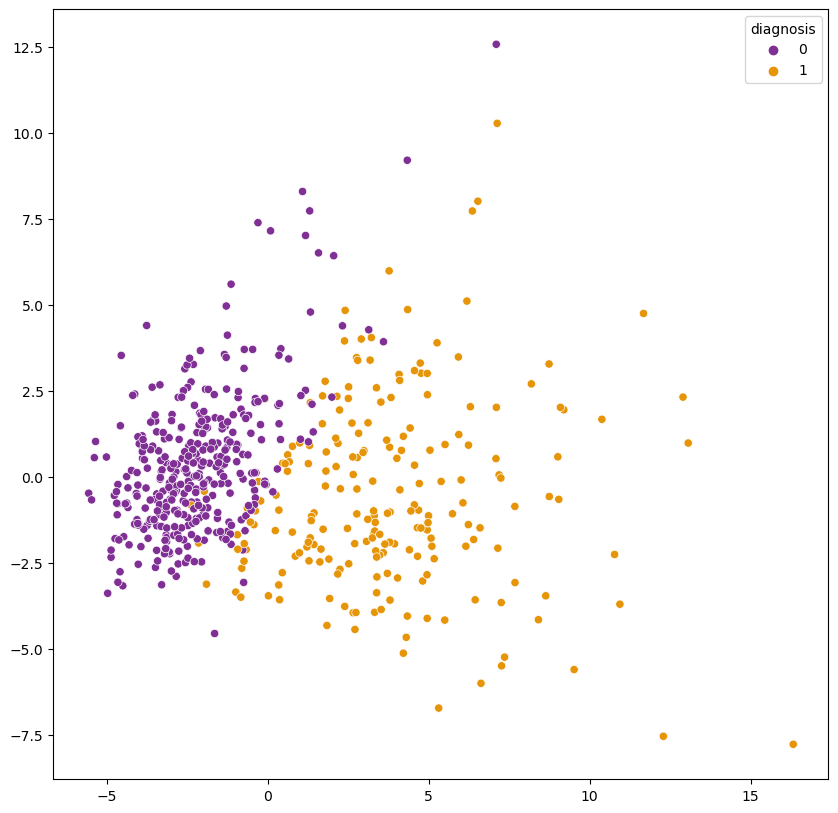

In [38]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=pca_transformed[:, 0],
    y=pca_transformed[:, 1],
    hue=y.astype(int),
    palette="CMRmap",
    legend="full",
);

In [39]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [41]:
x_train.shape

(398, 30)

In [42]:
lr = LogisticRegressionCV(cv=5)

In [43]:
lr.fit(x_train, y_train)

LogisticRegressionCV(cv=5)

In [44]:
y_pred = lr.predict_proba(x_test)[:, 1]

In [45]:
roc_auc_score(y_test, y_pred)

0.9978473019517795

In [46]:
def analyzePCA(X, pca, explained_threshold=0.95):
    """Plot cumulative explaned variance of PCA"""
    pca.fit(X)
    pca_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(15, 7))
    plt.plot(np.cumsum(pca_variance))
    plt.hlines(explained_threshold, 0, len(pca_variance))
    plt.title(
        "Number of components to explain {}% of variance: {}".format(
            100 * explained_threshold,
            np.argwhere(np.cumsum(pca_variance) > explained_threshold)[0],
        )
    )
    plt.xlabel("number of components")
    plt.ylabel("cumulative explained variance");

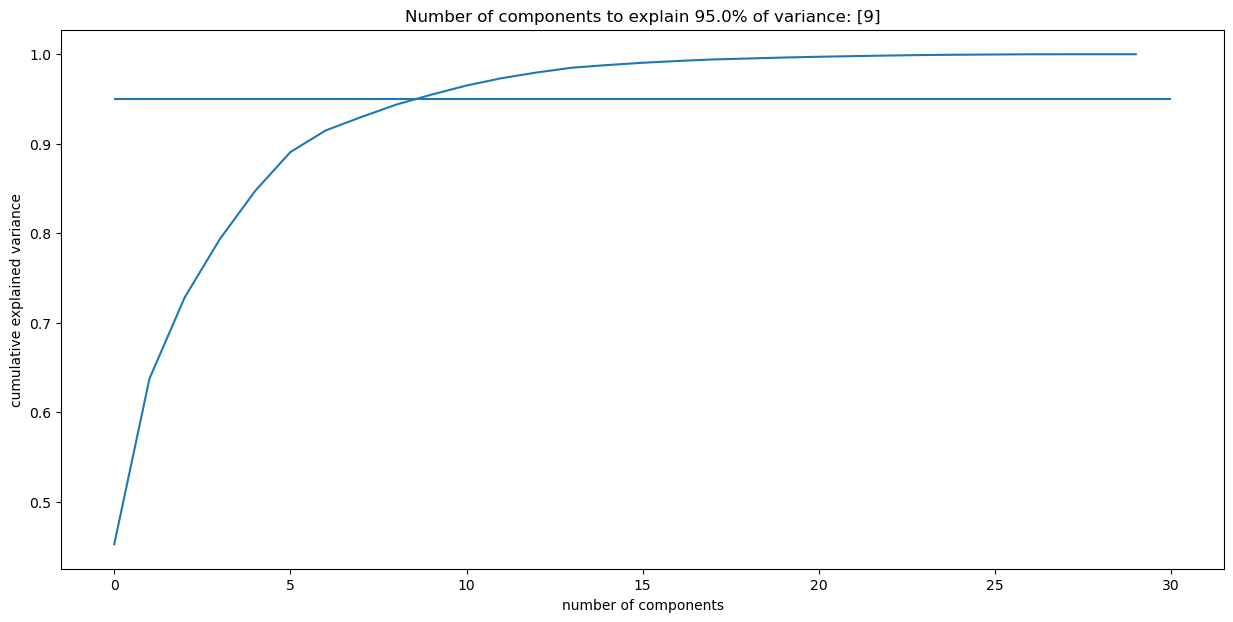

In [47]:
pca = PCA()
analyzePCA(x_train, pca, explained_threshold=0.95)

In [48]:
pca = PCA(n_components=9, random_state=42)
x_train_pca = pca.fit_transform(x_train)

In [49]:
x_train_pca.shape

(398, 9)

In [50]:
lr = LogisticRegressionCV(cv=5)
lr.fit(x_train_pca, y_train)
y_pred = lr.predict(pca.transform(x_test))
roc_auc_score(y_test, y_pred)

0.9802669345579793

# Дополнительные материалы
* https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/
* https://www.kaggle.com/nirajvermafcb/principal-component-analysis-explained
* https://plot.ly/ipython-notebooks/principal-component-analysis/
* https://coolstatsblog.com/2015/03/21/principal-component-analysis-explained/
* http://blog.districtdatalabs.com/principal-component-analysis-with-python